## 0.1 라이브러리 임포트


In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

## 0.2 하이퍼파라미터 셋팅

In [2]:
# Hyper-parameters 
sequence_length=28
input_size=28
hidden_size=128
num_layers=2

num_classes=10
batch_size=100
num_epochs=7
learning_rate=0.01

In [3]:
# Device configuration
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. MNIST train, test dataset 가져오기

In [4]:
mnist_train=dset.MNIST("",train=True,transform=transforms.ToTensor(),
                       target_transform=None, download=True) 
mnist_test=dset.MNIST("",train=False, transform=transforms.ToTensor(),
                      target_transform=None,download=True)

0it [00:00, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


0it [00:00, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw


0it [00:00, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw


0it [00:00, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...
Done!


## 2. 대략적인 데이터 형태

mnist_train 길이: 60000
mnist_test 길이: 10000
image data 형태: torch.Size([1, 28, 28])
label:  6


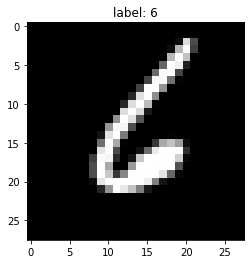

In [5]:
print ("mnist_train 길이:", len(mnist_train))
print ("mnist_test 길이:", len(mnist_test))

#데이터 하나 형태
image, label=mnist_train.__getitem__(1515)
print ("image data 형태:", image.size())
print ("label: ", label)

#그리기
img=image.numpy()
plt.title("label: %d" %label)
plt.imshow(img[0],cmap='gray')
plt.show()

## 3. 데이터 로드함수
학습시킬 때 batch_size 단위로 끊어서 로드하기 위함

In [6]:
train_loader=torch.utils.data.DataLoader(dataset=mnist_train,
                                         batch_size=batch_size, # mnist_train을 트레인 시키자.
                                         shuffle=True,
                                         drop_last=True) # batch_size 만큼 나눌 때 나머지는 버려라 
test_loader=torch.utils.data.DataLoader(dataset=mnist_test,
                                        batch_size=batch_size,
                                        shuffle=False, # test는 suhffle하지 않음
                                        drop_last=True)

### 데이터 로드함수 이해하기

[0]
한 번에 로드되는 데이터 크기:  100


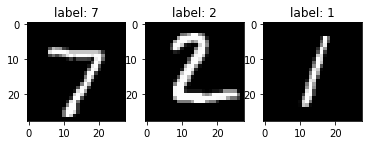

[1]
한 번에 로드되는 데이터 크기:  100


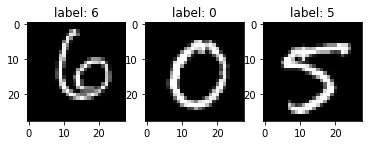

[2]
한 번에 로드되는 데이터 크기:  100


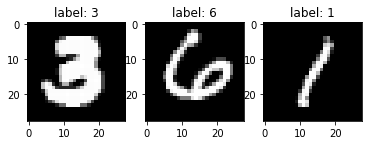

[3]
한 번에 로드되는 데이터 크기:  100


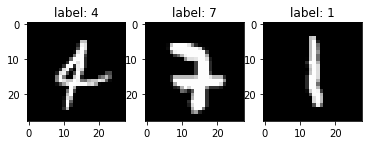

[4]
한 번에 로드되는 데이터 크기:  100


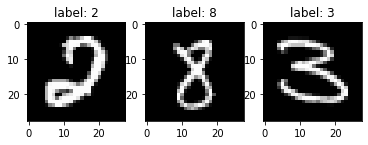

[5]
한 번에 로드되는 데이터 크기:  100


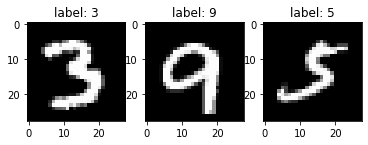

In [7]:
n=3 # 샘플로 그려볼 데이터 개수
for i, [imgs, labels] in enumerate(test_loader): # batch_size 만큼
    if i>5:
        break
        
    print ("[%d]" %i)
    print ("한 번에 로드되는 데이터 크기: ", len(imgs))
    
    #그리기
    for j in range(n):
        img=imgs[j].numpy() # image 타입을 numpy로 변환(1,28,28)
        img=img.reshape((img.shape[1],img.shape[2])) # (1,28,28)->(28,28)
        
        plt.subplot(1,n,j+1) # (1,3) 형태 플랏의 j번째 자리에 그리겠다
        plt.imshow(img, cmap='gray')
        plt.title("label: %d" %labels[j])
    plt.show()

## 4. 모델 선언

In [8]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size #128
        self.num_layers = num_layers # 2
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes) #128-10
        
    def forward(self, x):
        # -----------------
        # input tensor: (batch_size, seq_length, input_size) # bs, n, vector size
        # x: (100,28,28)
        # print('x: ', x.shape)
        
        # -----------------
        # hidden state tensor: (# of layers, batch_size, hidden_size)
        # h: (2, 100, 128)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # -----------------
        # Forward propagate LSTM
        # output tensor: (batch_size, seq_length, hidden_size)
        # out:(128,28,128)
        # print('out',out.shape)
        
        out, _ = self.lstm(x, (h0, c0))
        
        # -----------------
        # 28번째 output layer: (bs, hidden_size)
        # out[:,-1,:]: (100,128)
        # print('out[-1]:',out[:,-1,:].shape) 
        
        # -----------------
        out = self.fc(out[:, -1, :])
        
        # y^: (batch_size,num_classes)
        # y_pred:(100,10)
        # print('out: ',out.shape)
        
        return out

In [9]:
model=RNN(input_size,hidden_size,num_layers,num_classes).to(device)

In [10]:
def ComputeAccr(dloader, imodel):
    correct=0
    total=0
    
    for j, [imgs,labels] in enumerate(dloader): #batch_size 만큼
        # x: (batch_size, 1, seq_length, input_size) ->(batch_size, seq_length, input_size)
        img=imgs
        img=img.reshape(-1,sequence_length,input_size).to(device)
        
        # y: (batch_size, num_classes)
        label=labels.to(device) # y # Variable(labels)
        # label=Variable(labels).cuda()
        # .cuda(): GPU에 로드되기 위함, 만약 CPU로 설정되어 있다면 에러남
        
        # Forward prop.
        output=imodel(img) #(batch_size, num_classes)
        _, output_index=torch.max(output,1) # (batch_size, 1)
        
        total+=label.size(0)
        correct+=(output_index==label).sum().float()
    #print("Accuracy of Test Data: {}".format(100*correct/total))
    return (100*correct/total).cpu().numpy() # tensor -> numpy 

In [11]:
print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of Test Data: 11.78


## 5. Loss, optimizer

In [12]:
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

## 6. 학습

In [13]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, [imgs, labels] in enumerate(train_loader):
        # x: (batch_size, 1, seq_length, input_size) -> (batch_size, seq_length, input_size)
        img=imgs
        img=img.reshape(-1,sequence_length,input_size).to(device)
        
        # y: (batch_size, num_classes)
        label=labels.to(device) # y # Variable(labels)
        
        # Forward pass
        outputs = model(img)
        loss = loss_func(outputs, label)
        
        # Backward prop. & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accr:{:.2f}' 
                   .format(epoch+1, num_epochs, i+1, total_step,
                           loss.item(),
                           ComputeAccr(test_loader,model)))

Epoch [1/7], Step [100/600], Loss: 0.6256, Accr:79.85
Epoch [1/7], Step [200/600], Loss: 0.2734, Accr:93.00
Epoch [1/7], Step [300/600], Loss: 0.2486, Accr:94.50
Epoch [1/7], Step [400/600], Loss: 0.0615, Accr:95.46
Epoch [1/7], Step [500/600], Loss: 0.0855, Accr:96.71
Epoch [1/7], Step [600/600], Loss: 0.1685, Accr:96.08
Epoch [2/7], Step [100/600], Loss: 0.0606, Accr:97.25
Epoch [2/7], Step [200/600], Loss: 0.0645, Accr:97.27
Epoch [2/7], Step [300/600], Loss: 0.1165, Accr:97.59
Epoch [2/7], Step [400/600], Loss: 0.1342, Accr:97.53
Epoch [2/7], Step [500/600], Loss: 0.1214, Accr:97.64
Epoch [2/7], Step [600/600], Loss: 0.0146, Accr:98.02
Epoch [3/7], Step [100/600], Loss: 0.0523, Accr:97.71
Epoch [3/7], Step [200/600], Loss: 0.1180, Accr:97.43
Epoch [3/7], Step [300/600], Loss: 0.0412, Accr:98.03
Epoch [3/7], Step [400/600], Loss: 0.1905, Accr:97.89
Epoch [3/7], Step [500/600], Loss: 0.0114, Accr:98.01
Epoch [3/7], Step [600/600], Loss: 0.0299, Accr:98.07
Epoch [4/7], Step [100/600],

## 7. 테스트

In [14]:
print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of Test Data: 98.27


## 8. 학습된 파라미터 저장

In [16]:
netname='./rnn_weight.pkl'
torch.save(model, netname,)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## 9. 학습된 파라미터 로드

In [18]:
netname='./rnn_weight.pkl'
model=torch.load(netname)

In [19]:
print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of Test Data: 98.27
